<a href="https://colab.research.google.com/github/eavesly/sweetwater/blob/master/Copy_of_Naive_Gamma_Exposure_Calculator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Naive Gamma Exposure Calculator

Definitely not [SpotGamma](https://spotgamma.com/)™ - just a start before reading [SqueezeMetrics whitepapers](https://squeezemetrics.com/monitor/docs)

The original article by [#perfiliev](https://twitter.com/perfiliev) is [here](https://perfiliev.co.uk/market-commentary/how-to-calculate-gamma-exposure-and-zero-gamma-level/). Discussion is [here](https://twitter.com/perfiliev/status/1490334315082878982?s=20&t=pJtMn9C2fuJwZY7II4sJcg)

Formulas used can be found [here](https://www.macroption.com/black-scholes-formula/)

Discussion with Cem Karsan 🥐 [here](https://twitter.com/jam_croissant/status/1490019302589747206).

Select symbol in a dropdown, then run all cells with Shift-Enter.

In [ ]:
#@title 

symbol = '_SPX'  # @param ["_SPX", "_NDX", "_RUT"]

import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import requests
from scipy.stats import norm


import json

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import requests
from scipy.stats import norm


def get_cboe_options_chain(symbol):
    s = requests.Session()
    response = s.get(f'https://cdn.cboe.com/api/global/delayed_quotes/options/{symbol}.json')
    data = json.loads(response.content)
    s.close()
    quote = data['data']
    options = pd.DataFrame(quote['options'])
    quote.pop('options')

    options[['symbol', 'expiration_date', 'put_call', 'strike_price']] = options.option.str.extract(r'([A-Z]+)(\d{6})([CP])(\d+)')
    options['expiration_date'] = pd.to_datetime(options.expiration_date, yearfirst=True)

    for c in ['strike_price', 'open_interest', 'iv', 'gamma']:
        options[c] = pd.to_numeric(options[c])
    options['strike_price'] = options['strike_price'] / 1000
    snapshot_time = pd.to_datetime(data['timestamp'])
    options['days_to_expiration'] = np.busday_count(pd.Series(snapshot_time).dt.date, options['expiration_date'].dt.date) / 262

    return quote, options, snapshot_time


def get_gamma_pivot(chain, field, sorted=True):
    chain = chain[[field, 'total_gamma']].groupby(field).sum()
    chain = chain.reset_index()
    if sorted:
        chain = chain.sort_values(by=field).reset_index(drop=True)
    return chain


# Black-Scholes European-Options Gamma
# https://www.macroption.com/black-scholes-formula/
def _calcGammaExCall(S, K, iv, T, r, q, OI):
    d1 = (np.log(S / K) + T * (r - q + 0.5 * iv ** 2)) / (iv * np.sqrt(T))
    # d2 = d1 - iv * np.sqrt(T)
    gamma = np.exp(-q * T) * norm.pdf(d1) / (S * iv * np.sqrt(T))
    return OI * 100 * S * S * 0.01 * gamma


def _isThirdFriday(d):
    return d.weekday() == 4 and 15 <= d.day <= 21


def _gamma_range(quote, from_range=0.8, to_range=1.2):
    spotPrice = quote['current_price']
    fromStrike = from_range * spotPrice
    toStrike = to_range * spotPrice
    return spotPrice, fromStrike, toStrike


def naive_gamma(quote, options):
    spotPrice, fromStrike, toStrike = _gamma_range(quote)

    levels = np.linspace(fromStrike, toStrike, 60)
    
    # For 0DTE options, I'm setting DTE = 1 day, otherwise they get excluded
    options.loc[options['days_to_expiration'] == 0, 'days_to_expiration'] = 1/262
    
    nextExpiry = options.expiration_date.min()
    options['isThirdFriday'] = options.expiration_date.apply(_isThirdFriday)
    thirdFridays = options.loc[options.isThirdFriday]
    nextMonthlyExp = thirdFridays.expiration_date.min()

    totalGamma = []
    totalGammaExNext = []
    totalGammaExFri = []

    # For each spot level, calc gamma exposure at that point
    df = options.copy()
    for level in levels:
        df_ = df[df.put_call == 'C']
        df.loc[df_.index, 'callGammaEx'] = _calcGammaExCall(level, df_.strike_price, df_.iv, df_.days_to_expiration, 0, 0, df_.open_interest)

        df_ = df[df.put_call == 'P']
        df.loc[df_.index, 'putGammaEx'] = _calcGammaExCall(level, df_.strike_price, df_.iv, df_.days_to_expiration, 0, 0, df_.open_interest)

        totalGamma.append(df.callGammaEx.sum() - df.putGammaEx.sum())

        exNxt = df.loc[df.expiration_date != nextExpiry]
        totalGammaExNext.append(exNxt.callGammaEx.sum() - exNxt.putGammaEx.sum())

        exFri = df.loc[df.expiration_date != nextMonthlyExp]
        totalGammaExFri.append(exFri.callGammaEx.sum() - exFri.putGammaEx.sum())

    totalGamma = np.array(totalGamma) / 10 ** 9
    totalGammaExNext = np.array(totalGammaExNext) / 10 ** 9
    totalGammaExFri = np.array(totalGammaExFri) / 10 ** 9

    # Find Gamma Flip Point
    zeroCrossIdx = np.where(np.diff(np.sign(totalGamma)))[0]

    negGamma = totalGamma[zeroCrossIdx]
    posGamma = totalGamma[zeroCrossIdx + 1]
    negStrike = levels[zeroCrossIdx]
    posStrike = levels[zeroCrossIdx + 1]

    # Writing and sharing this code was only possible with your support!
    # If you find it useful, consider supporting us at perfiliev.com/support :)
    zeroGamma = posStrike - ((posStrike - negStrike) * posGamma / (posGamma - negGamma))
    zeroGamma = zeroGamma[0]

    return quote, levels, totalGamma, totalGammaExNext, totalGammaExFri, zeroGamma, nextExpiry, nextMonthlyExp


def spot_gamma(df, spot):
    # Gamma Exposure = Unit Gamma * Open Interest * Contract Size * Spot Price
    # To further convert into 'per 1% move' quantity, multiply by 1% of spotPrice
    df = options.copy()

    groups = options.option.str.extract(r'([A-Z]+\d{6})[CP](\d+)')
    df['key'] = [f'{prefix}@{strike}' for (prefix, strike) in zip(groups[0], groups[1])]
    df_ = df[df.put_call == 'C']
    df.loc[df_.index, 'GEX'] = df_.gamma * df_.open_interest * 100 * spot * spot * 0.01
    df_ = df[df.put_call == 'P']
    df.loc[df_.index, 'GEX'] = df_.gamma * df_.open_interest * 100 * spot * spot * 0.01 * -1

    df = df[df.put_call == 'C'].merge(df[df.put_call == 'P'], on=['key', 'strike_price'], suffixes=['_call', '_put'])
    df['total_gamma'] = (df.GEX_call + df.GEX_put) / 10**9
    df_agg = df[['strike_price', 'GEX_call', 'GEX_put', 'total_gamma']].groupby('strike_price').sum().reset_index()

    return df_agg


def plot_gamma_exposure(todayDate, quote, levels, totalGamma, totalGammaExNext, totalGammaExFri, zeroGamma, nextExpiry, nextMonthlyExp):
    # Plot Gamma Exposure Profile
    spotPrice, fromStrike, toStrike = _gamma_range(quote)
    fig, ax = plt.subplots(figsize=(24, 6))
    plt.grid(True)
    plt.plot(levels, totalGamma, label="All Expiries")
    plt.plot(levels, totalGammaExNext, label=f"Ex-Next Expiry {nextExpiry.strftime('%d %b %Y')}")
    plt.plot(levels, totalGammaExFri, label=f"Ex-Next Monthly Expiry {nextMonthlyExp.strftime('%d %b %Y')}")
    chartTitle = f"Gamma Exposure Profile, {quote['symbol']}, {todayDate.strftime('%d %b %Y')}"
    plt.title(chartTitle, fontweight="bold", fontsize=20)
    plt.xlabel('Index Price', fontweight="bold")
    plt.ylabel('Gamma Exposure ($ billions/1% move)', fontweight="bold")
    plt.axvline(x=spotPrice, color='r', lw=1, label=f"{quote['symbol']} Spot: {spotPrice:,.0f}")
    plt.axvline(x=zeroGamma, color='g', lw=1, label=f"Gamma Flip: {zeroGamma:,.0f}")
    plt.axhline(y=0, color='grey', lw=1)
    plt.xlim([fromStrike, toStrike])
    trans = ax.get_xaxis_transform()
    plt.fill_between([fromStrike, zeroGamma], min(totalGamma), max(totalGamma), facecolor='red', alpha=0.1, transform=trans)
    plt.fill_between([zeroGamma, toStrike], min(totalGamma), max(totalGamma), facecolor='lime', alpha=0.1, transform=trans)
    plt.legend()
    ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=25))
    plt.show()
    

def plot_absoulte_gamma_exposure(quote, df_agg):
    spotPrice, fromStrike, toStrike = _gamma_range(quote)
    fig, ax = plt.subplots(figsize=(24, 6))
    plt.grid(True)
    plt.bar(df_agg.strike_price, df_agg['total_gamma'].to_numpy(), width=6, linewidth=0.1, edgecolor='k', label="Gamma Exposure")
    plt.xlim([fromStrike, toStrike])
    title = f"Total Gamma: ${df_agg.total_gamma.sum():.2f} Bn per 1% {quote['symbol']} Move"
    plt.title(title, fontweight="bold", fontsize=20)
    plt.xlabel('Strike', fontweight="bold")
    plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
    plt.axvline(x=spotPrice, color='r', lw=1, label=f"{quote['symbol']} Spot - {spotPrice:,.0f}")
    plt.legend()
    plt.show()


def plot_absoulte_gamma_exposure_by_calls_and_puts(quote, df_agg):
    spotPrice, fromStrike, toStrike = _gamma_range(quote)
    fig, ax = plt.subplots(figsize=(24, 6))
    plt.grid(True)
    plt.bar(df_agg.strike_price, df_agg['GEX_call'].to_numpy() / 10 ** 9, width=6, linewidth=0.1, edgecolor='k', label="Call Gamma")
    plt.bar(df_agg.strike_price, df_agg['GEX_put'].to_numpy() / 10 ** 9, width=6, linewidth=0.1, edgecolor='k', label="Put Gamma")
    plt.xlim([fromStrike, toStrike])
    title = f"Total Gamma: ${df_agg.total_gamma.sum():.2f} Bn per 1% {quote['symbol']} Move"
    plt.title(title, fontweight="bold", fontsize=20)
    plt.xlabel('Strike', fontweight="bold")
    plt.ylabel('Spot Gamma Exposure ($ billions/1% move)', fontweight="bold")
    plt.axvline(x=spotPrice, color='r', lw=1, label=f"{quote['symbol']} Spot - {spotPrice:,.0f}")
    plt.legend()
    plt.show()


def plot_index_gamma_report(quote, options, snapshot_time):
    spot_price = quote['current_price']
    gamma_params = naive_gamma(quote, options)
    plot_gamma_exposure(snapshot_time, *gamma_params)
    df = spot_gamma(options, spot_price)
    plot_absoulte_gamma_exposure(quote, df)
    plot_absoulte_gamma_exposure_by_calls_and_puts(quote, df)



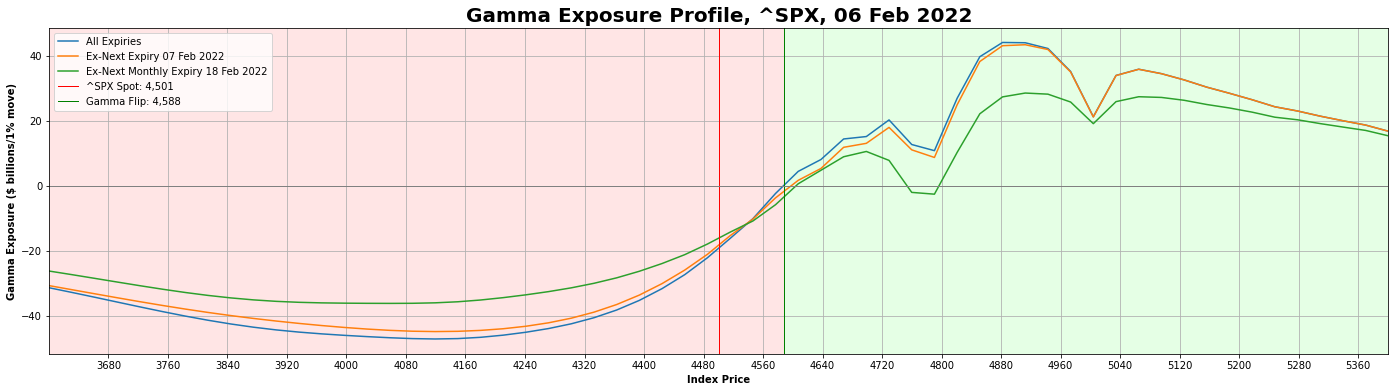

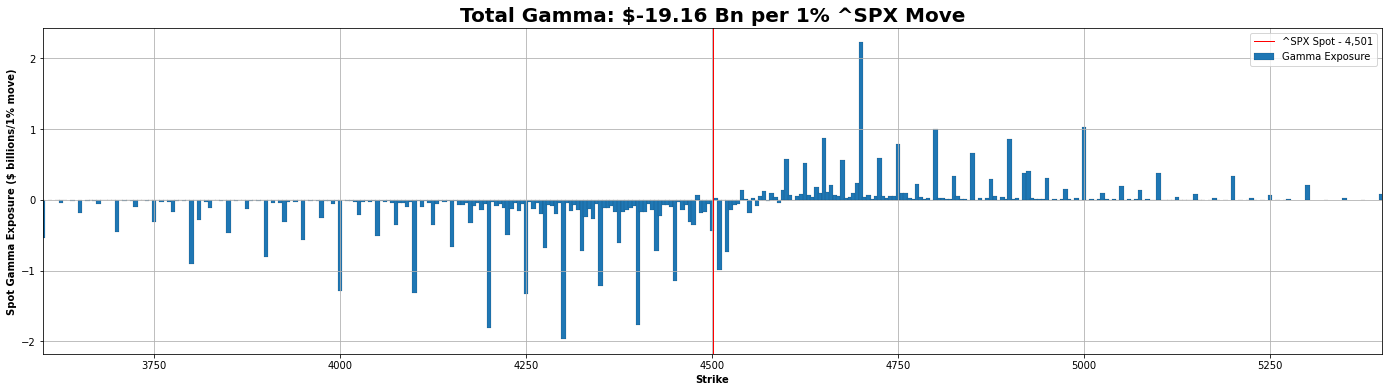

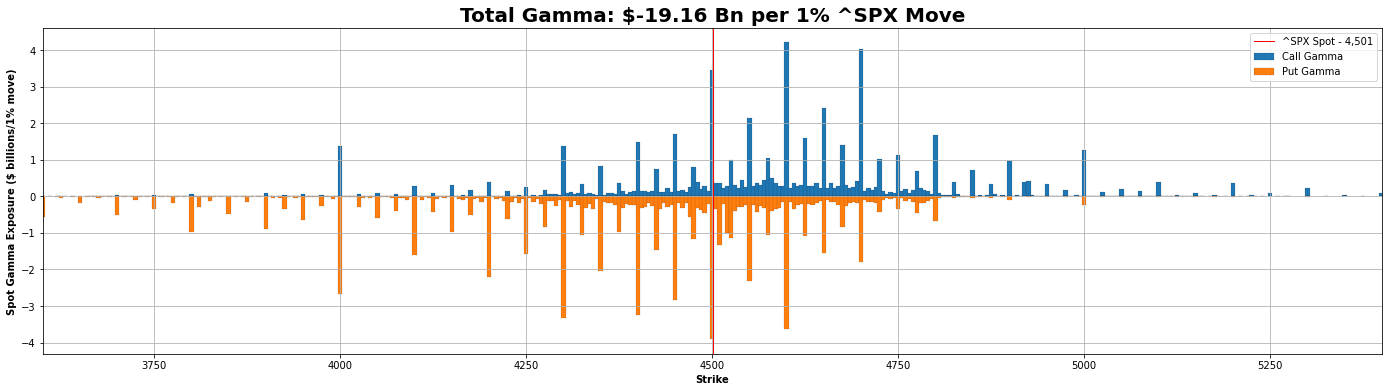

In [ ]:
#@title
quote, options, snapshot_time = get_cboe_options_chain(symbol)
plot_index_gamma_report(quote, options, snapshot_time)